In [1]:
import numpy as np
from scipy.stats import multivariate_normal, multivariate_t
import os
import torch
import pandas as pd
from sklearn.cluster import KMeans
from preprocess import get_csv
from sklearn.metrics.pairwise import cosine_similarity
import logging
import matplotlib.pyplot as plt
import seaborn as sns

/home/yys/.conda/envs/baselines/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def kl_divergence(X0, X1):
    mean0 = np.mean(X0, axis=0)
    cov0 = np.cov(X0, rowvar=False)
    mean1 = np.mean(X1, axis=0)
    cov1 = np.cov(X1, rowvar=False)

    print(np.mean(cov0))
    print(np.max(cov0))
    print(np.mean(cov1))
    print(np.max(cov1))

    mvn0 = multivariate_normal(mean=mean0, cov=cov0, allow_singular = True)
    mvn1 = multivariate_normal(mean=mean1, cov=cov1, allow_singular = True)
    
    # X = mvn0.rvs(size=1000)
    
    pdf0 = mvn0.logpdf(X0)
    pdf1 = mvn1.logpdf(X0)
    
    for i in range(pdf0.shape[0]):
        if pdf0[i] == -np.inf:
            pdf0[i] = -1e5
    for i in range(pdf1.shape[0]):
        if pdf1[i] == -np.inf:
            pdf1[i] = -1e5
    
    kl_div = np.mean(pdf0-pdf1)
    
    return kl_div
    

In [18]:
def cos_similarity(X0, X1):
    if (X0.shape[0] == 0) or (X1.shape[0] == 0):
        return -1
    X0 = X0/np.linalg.norm(X0, axis=1)[:, np.newaxis]
    X1 = X1/np.linalg.norm(X1, axis=1)[:, np.newaxis]
    
    cos_sim = cosine_similarity(X0, X1)
    avg_sim = np.mean(cos_sim)
    
    return avg_sim

In [4]:
embeddings_path = 'embeddings.npy'

# Check if the file exists
if not os.path.exists(embeddings_path):
    # If the file does not exist, call the get_embedding method
    print("Creating CSV from JSON file.")
    corpus_embeddings = model.encode(corpus, show_progress_bar=True)
    np.save("./embeddings.npy", corpus_embeddings, allow_pickle=True)
else:
    print("The file already exists.")
    corpus_embeddings = np.load("./embeddings.npy", allow_pickle=True)

print(corpus_embeddings.shape)

The file already exists.
(2370685, 384)


In [2]:
clusters = np.load("./clusters_11.npy", allow_pickle=True)

In [3]:
names = ['math.AG', 'astro-ph', 
         'hep-th', 'hep-ph',
         'math.CO', 'cs.LG',
         'qua-ph', 'cs.IT',
         'material', 'math.AP',
         'mech']

In [ ]:
# kldivergence

kld = np.zeros((11, 11))

for i in range(11):
    print(f'i:{i}')
    for j in range(11):
        print(f'j:{j}')
        kld[i,j] = kl_divergence(corpus_embeddings[np.where(clusters==i)[0]], corpus_embeddings[np.where(clusters==j)[0]])
        

In [6]:
cos = np.zeros((11, 11))

for i in range(11):
    for j in range(11):
        cos[i,j] = cos_similarity(corpus_embeddings[np.where(clusters==i)[0]], corpus_embeddings[np.where(clusters==j)[0]])

In [56]:
def create_sim_matrix(sim, title = 'hello', name = 'hi.png', fmt=".0f"):
    folder_name = "Matrix"

    # Create the folder if it doesn't exist
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    # Check if the data is a square matrix
    if sim.shape[0] != sim.shape[1]:
        logging.info("Data is not in the correct format. It should be a square matrix.")
        return
    
    # Reverse the order of the columns
    # data = data[data.columns[::-1]]

    plt.figure()
    heatmap = sns.heatmap(sim, annot=True, cmap='coolwarm', fmt = fmt, xticklabels=names, yticklabels=names)
    plt.title(title)
    plt.tight_layout()
    # plt.xticks(ticks=names)

    # Save the matrix to the specified folder
    save_path = os.path.join(folder_name, name)
    heatmap.figure.savefig(save_path)
    logging.info(f"matrix saved to {save_path}")

    # Optionally, display the matrix
    plt.show()

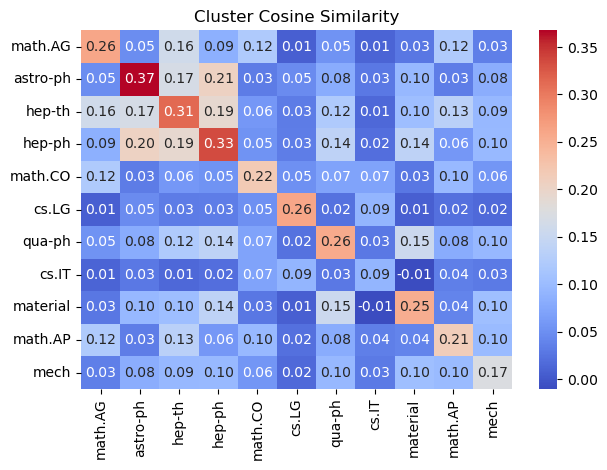

In [59]:
# create_sim_matrix(kld[:10,:10], title='kld', name='kld_matrix.png')
create_sim_matrix(cos[:11,:11], title='Cluster Cosine Similarity', name='cos_matrix.png', fmt=".2f")

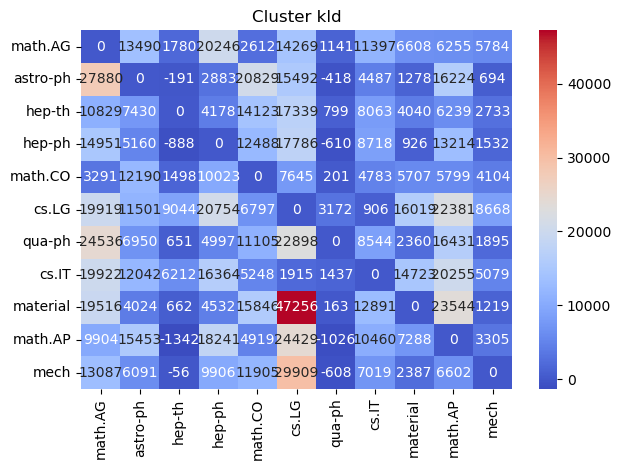

In [69]:
create_sim_matrix(kld[:11,:11], title='Cluster kld', name='kld_matrix.png')

In [13]:
np.save("./cos_all.npy", cos, allow_pickle=True)

In [5]:
years = np.load("./years.npy", allow_pickle=True)

In [ ]:
cos_years = np.zeros((38, 11, 11))

for i in range(38):
    print(i)
    for j in range(11):
        for k in range(j,11):
            cos_years[i,j,k] = cos_similarity(corpus_embeddings[np.where((clusters==j) & (years==1986+i))],
                                              corpus_embeddings[np.where((clusters==k) & (years==1986+i))])
            cos_years[i,k,j] = cos_years[i,j,k]
        

In [32]:
np.save("./cos_years.npy", cos_years, allow_pickle=True)

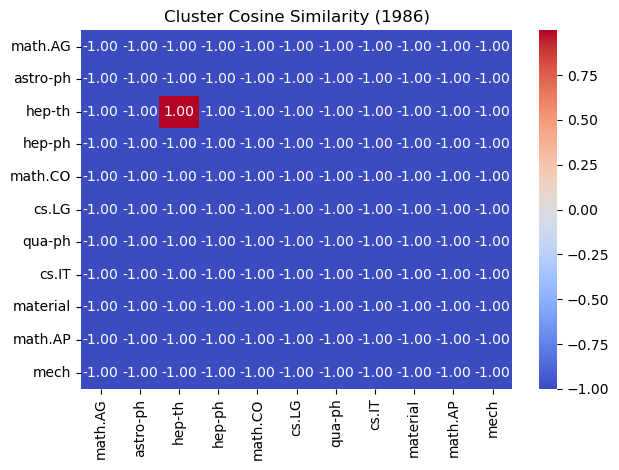

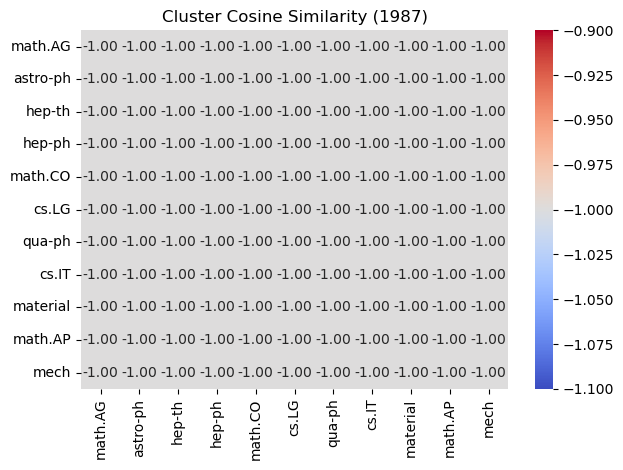

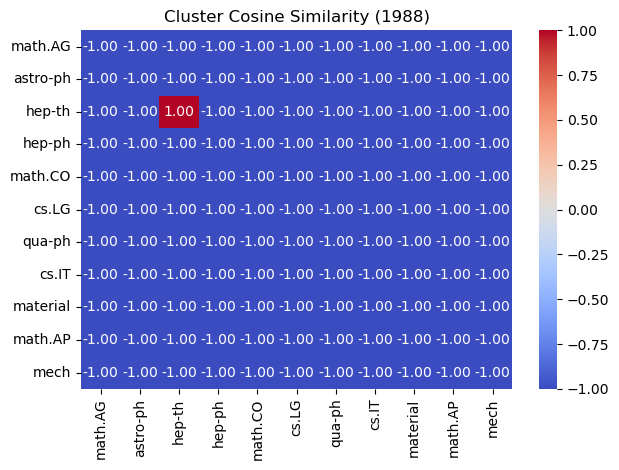

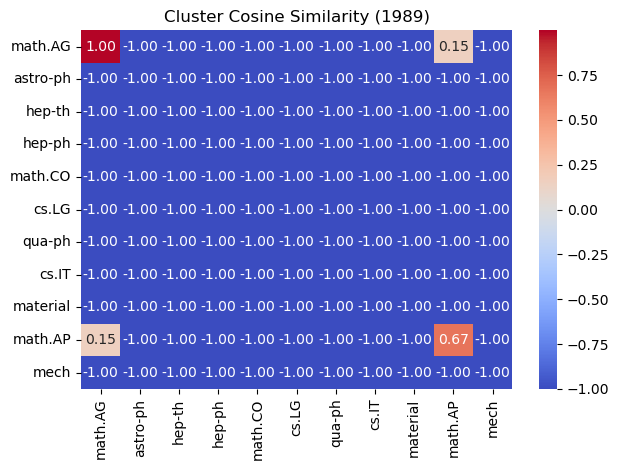

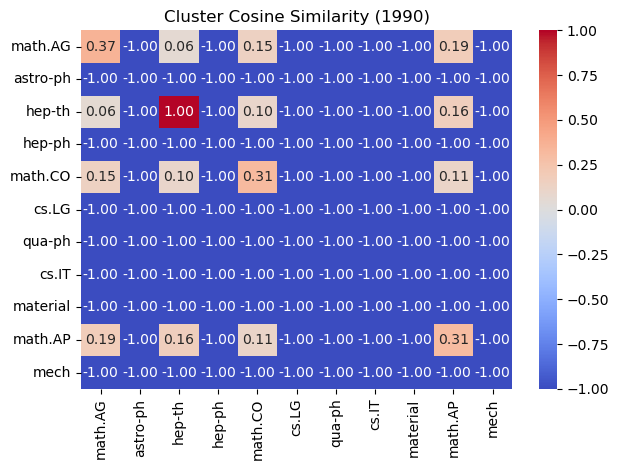

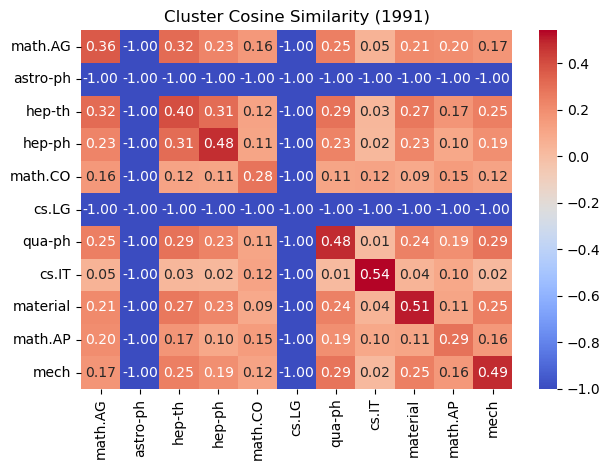

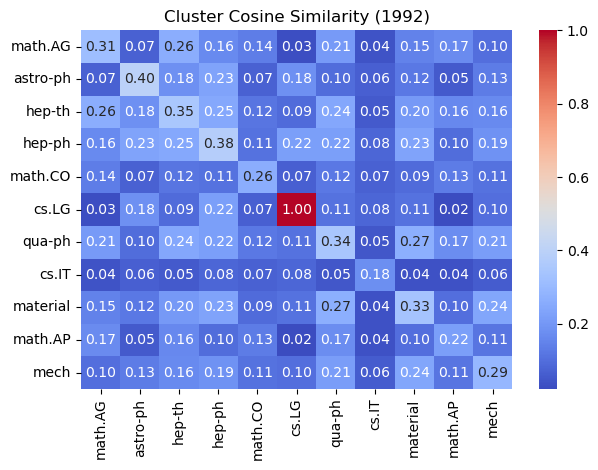

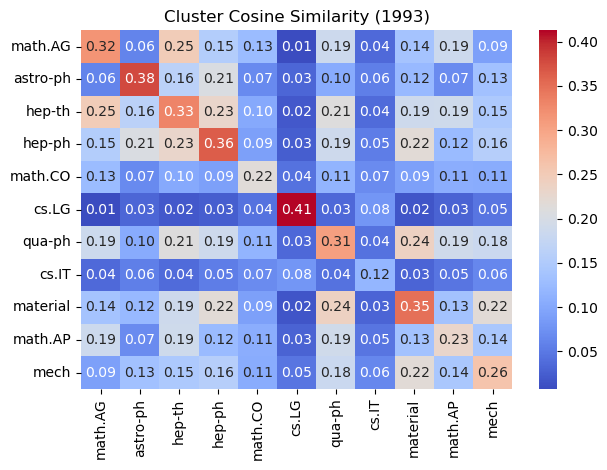

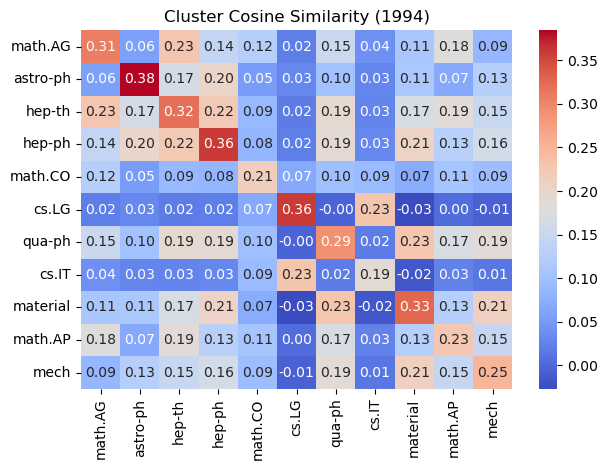

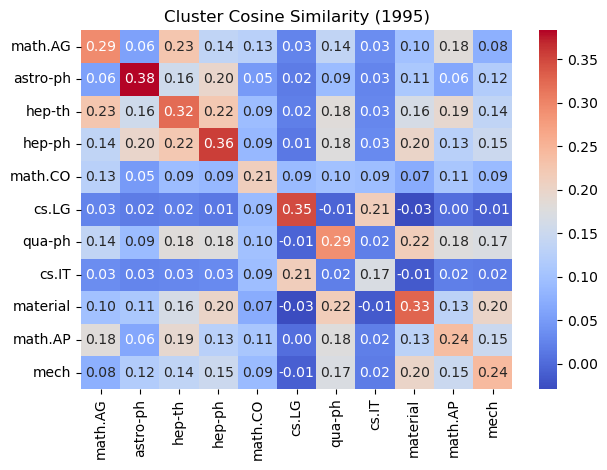

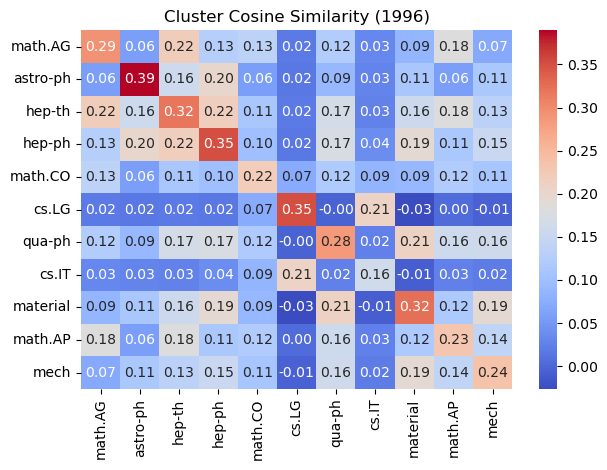

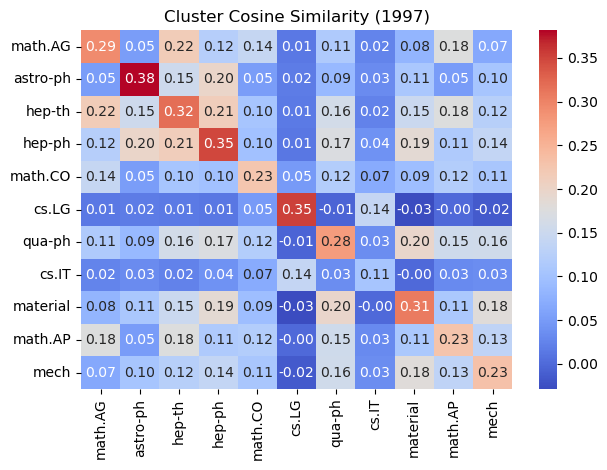

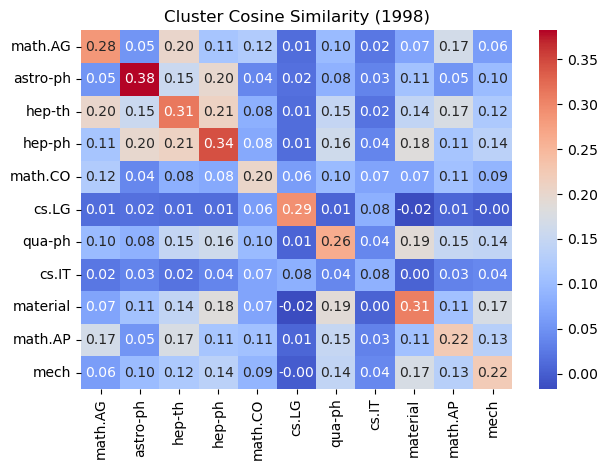

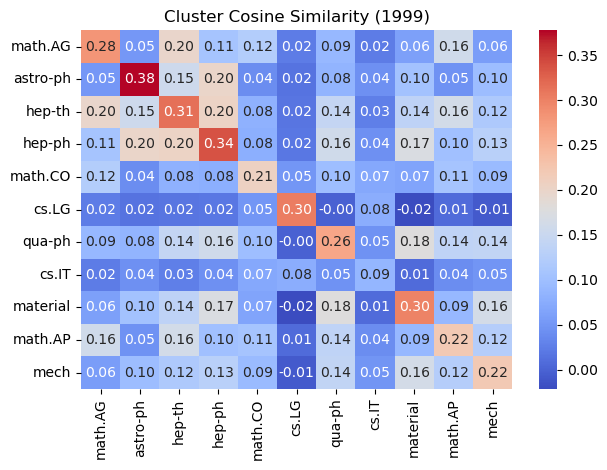

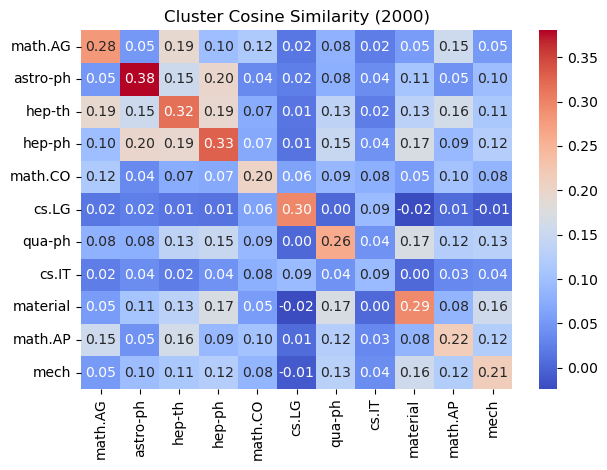

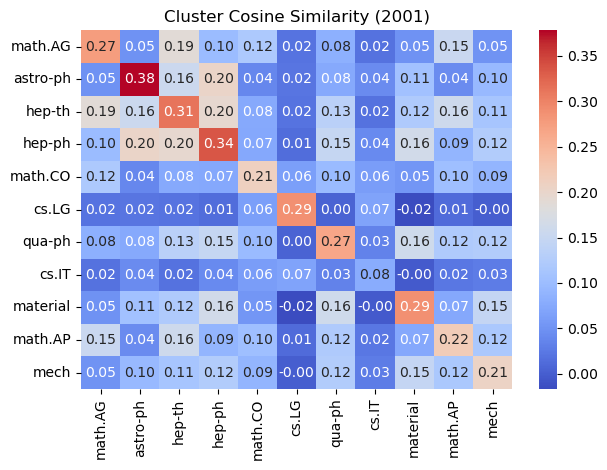

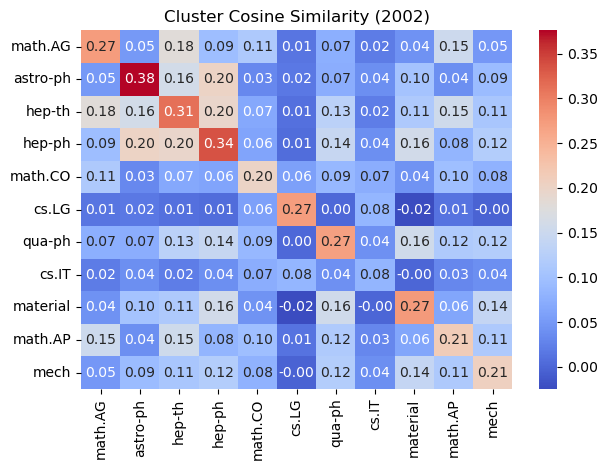

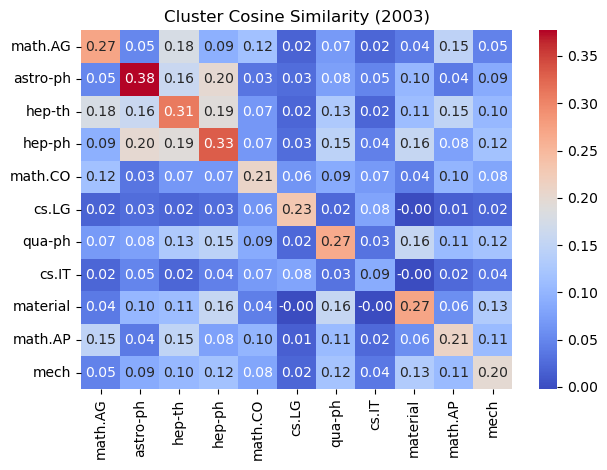

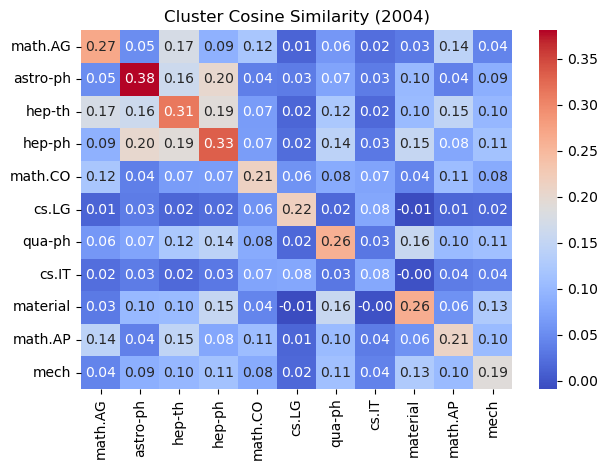

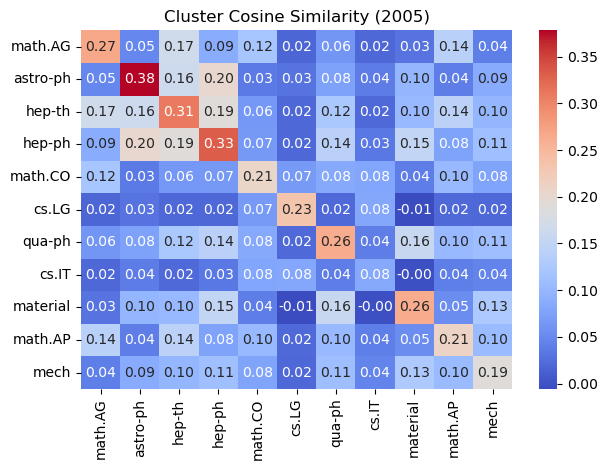

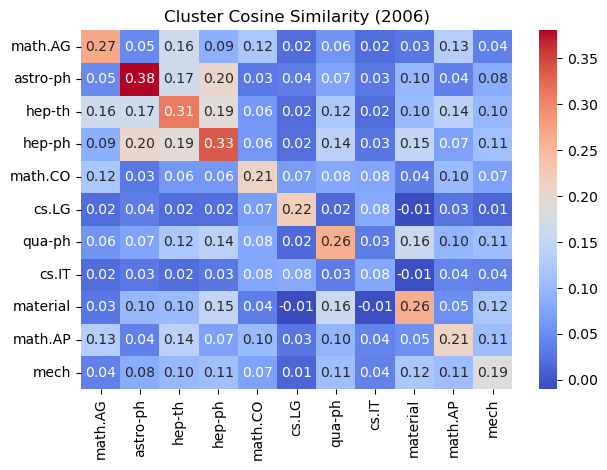

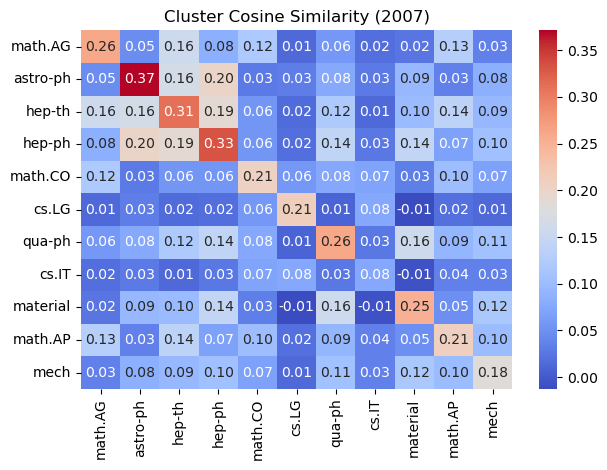

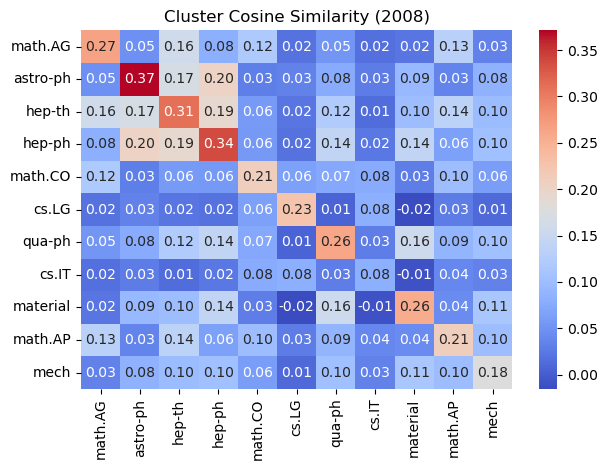

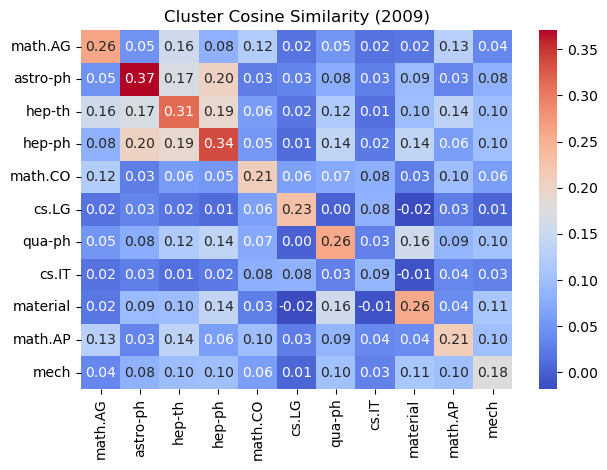

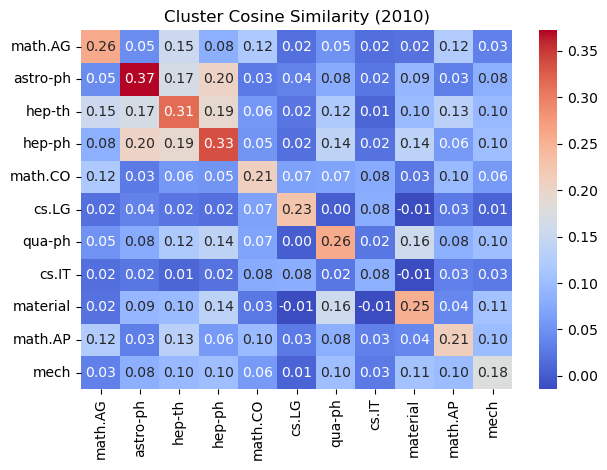

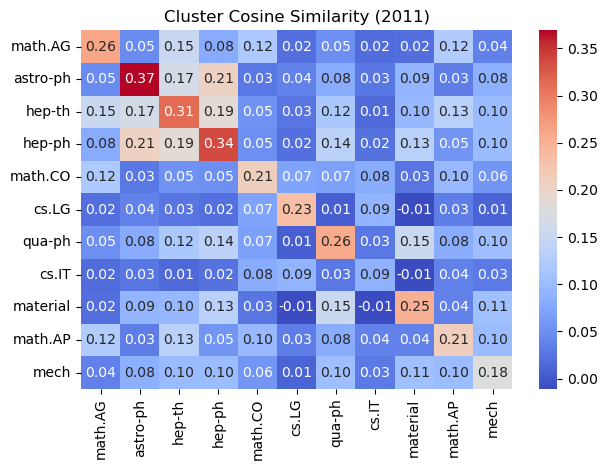

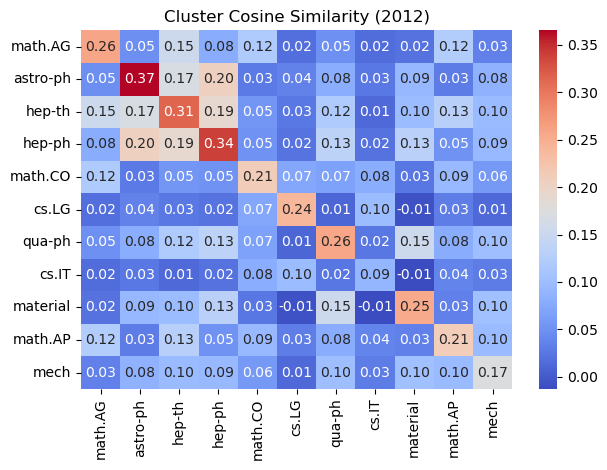

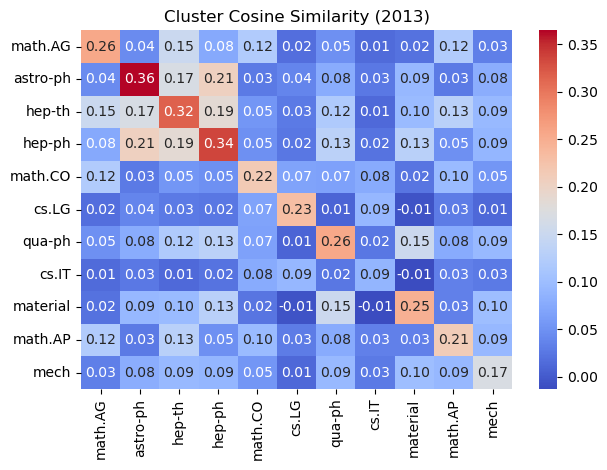

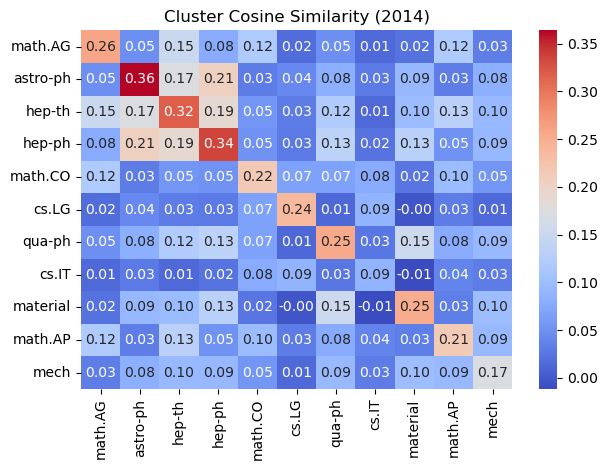

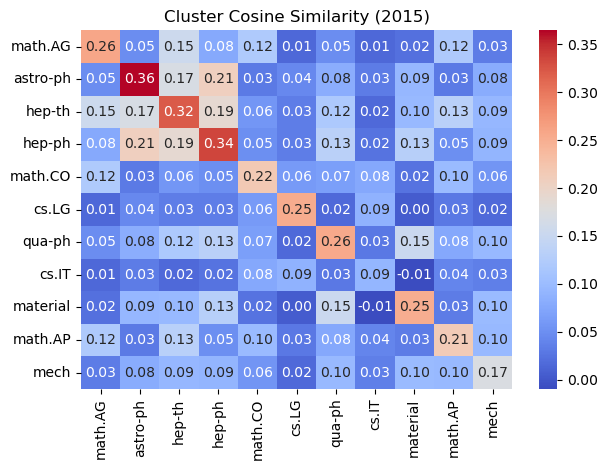

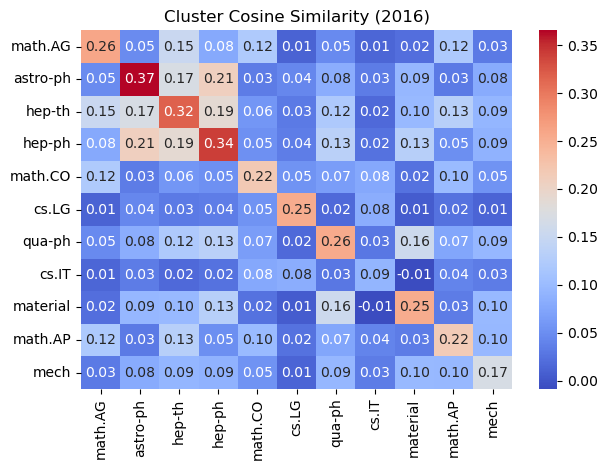

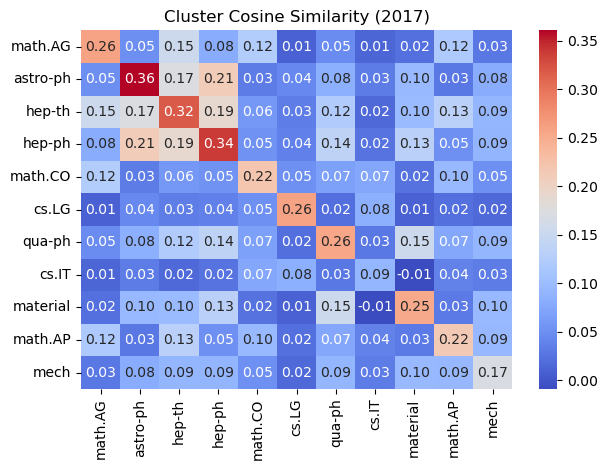

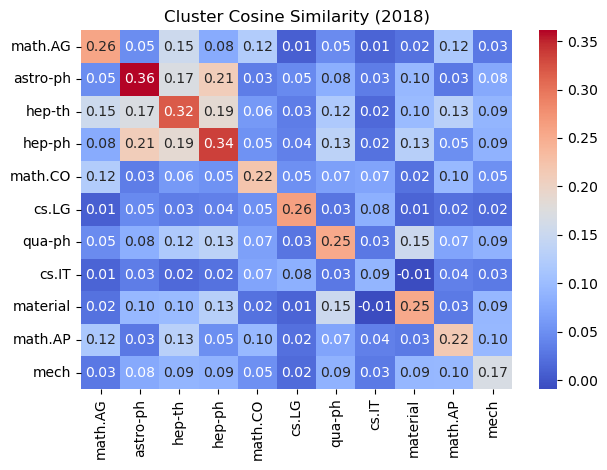

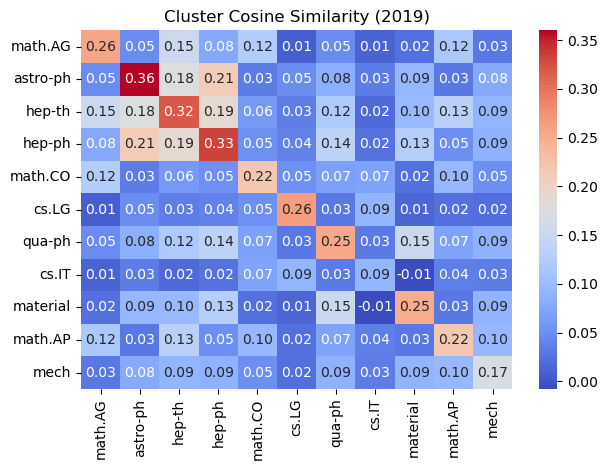

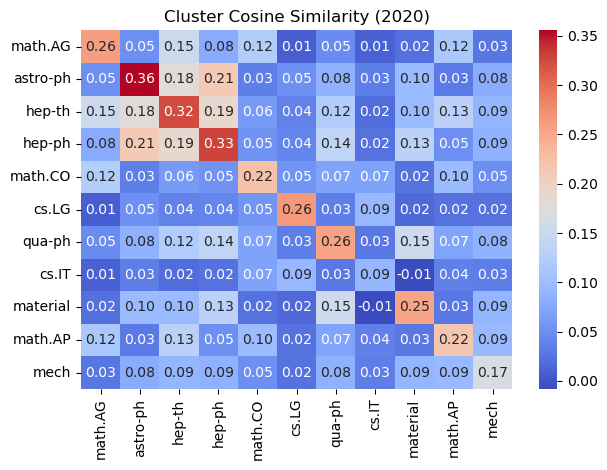

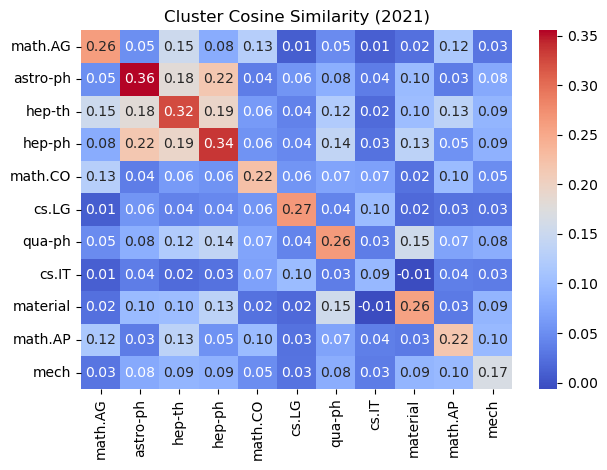

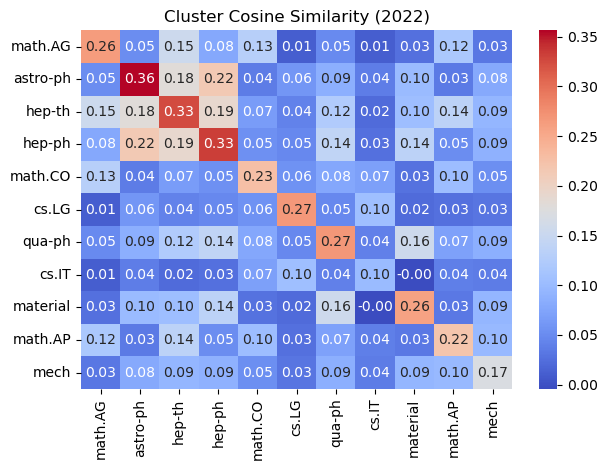

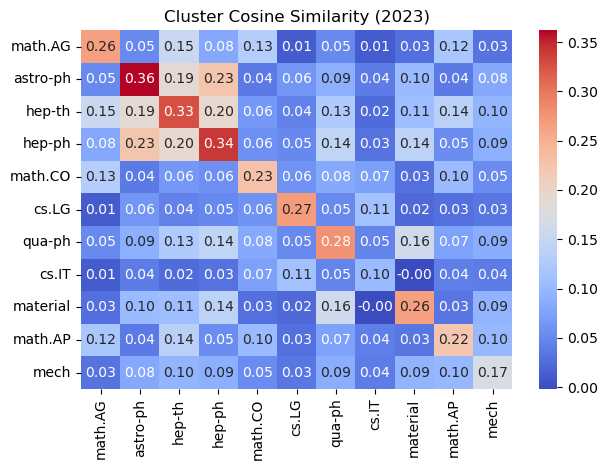

In [67]:
for i in range(38):
    create_sim_matrix(cos_years[i][:11,:11], title=f'Cluster Cosine Similarity ({1986+i})', name=f'cos_matrix_{1986+i}', fmt='.2f')

In [36]:
divide_years = [1986, 1991, 1996, 2001, 2006, 2011, 2016, 2021, 2026]

cos_clusters = np.zeros((11, len(divide_years)-1, len(divide_years)-1))

for i in range(11):
    print(i)
    for j in range(len(divide_years)-1):
        for k in range(j, len(divide_years)-1):
            cos_clusters[i,j,k] = cos_similarity(corpus_embeddings[np.where((clusters==i) & (years>=divide_years[j]) & (years<divide_years[j+1]))[0]], 
                                                 corpus_embeddings[np.where((clusters==i) & (years>=divide_years[k]) & (years<divide_years[k+1]))[0]])
            cos_clusters[i,k,j] = cos_clusters[i,j,k]


0
1
2
3
4
5
6
7
8
9
10


In [70]:
divide_years = [1986, 1991, 1996, 2001, 2006, 2011, 2016, 2021, 2024]
divided_years = []
for i in range(len(divide_years)-1):
    divided_years.append(f'{divide_years[i]}-{divide_years[i+1]-1}')
print(divided_years)

['1986-1990', '1991-1995', '1996-2000', '2001-2005', '2006-2010', '2011-2015', '2016-2020', '2021-2023']


In [37]:
np.save("./cos_clusters.npy", cos_clusters, allow_pickle=True)

In [55]:
cos_clusters = np.load("./cos_clusters.npy", allow_pickle=True)

In [71]:
def create_year_matrix(sim, title = 'hello', name = 'hi.png', fmt=".0f"):
    folder_name = "Matrix/years"

    # Create the folder if it doesn't exist
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    # Check if the data is a square matrix
    if sim.shape[0] != sim.shape[1]:
        logging.info("Data is not in the correct format. It should be a square matrix.")
        return
    
    # Reverse the order of the columns
    # data = data[data.columns[::-1]]
    plt.figure()
    # heatmap = sns.heatmap(sim, vmin=0, vmax=1, annot=True, cmap='PiYG', fmt = fmt)
    heatmap = sns.heatmap(sim, vmin=0, vmax=1, annot=True, cmap='coolwarm', fmt = fmt, xticklabels=divided_years[1:], yticklabels=divided_years[1:])
    plt.title(title)
    plt.tight_layout()

    # Save the matrix to the specified folder
    save_path = os.path.join(folder_name, name)
    heatmap.figure.savefig(save_path)
    logging.info(f"matrix saved to {save_path}")

    # Optionally, display the matrix
    plt.show()

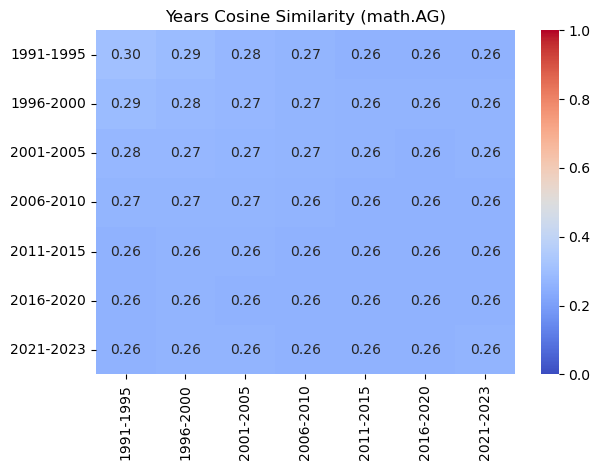

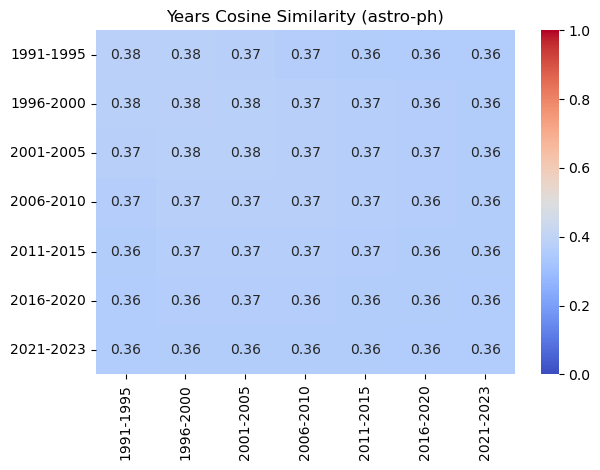

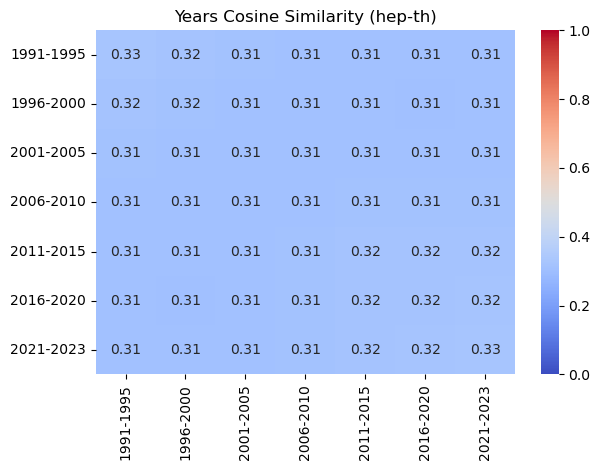

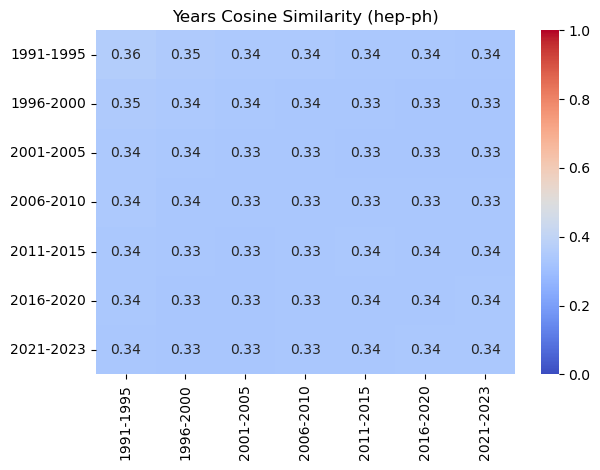

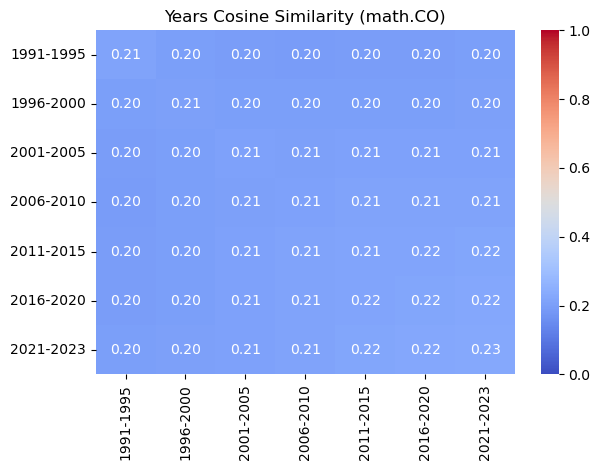

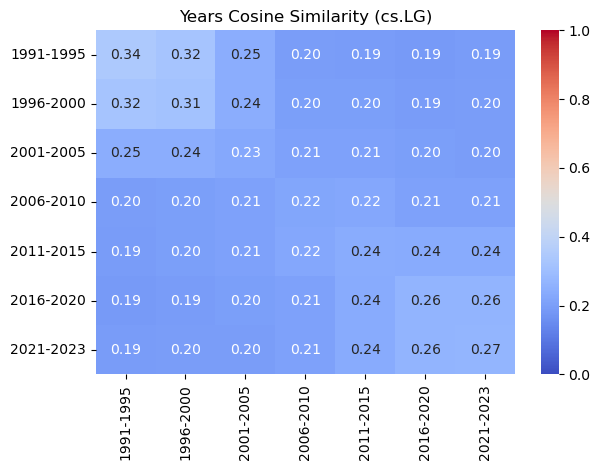

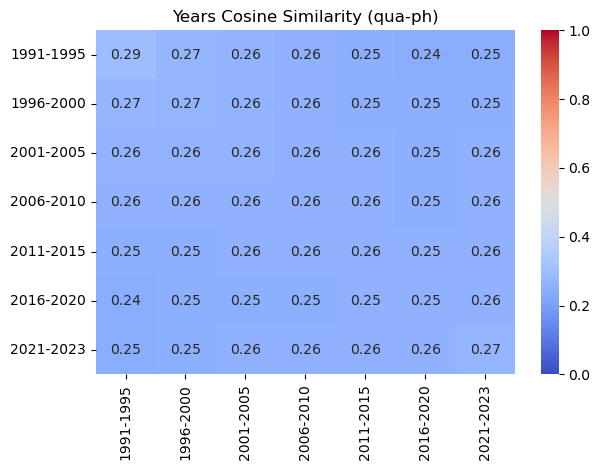

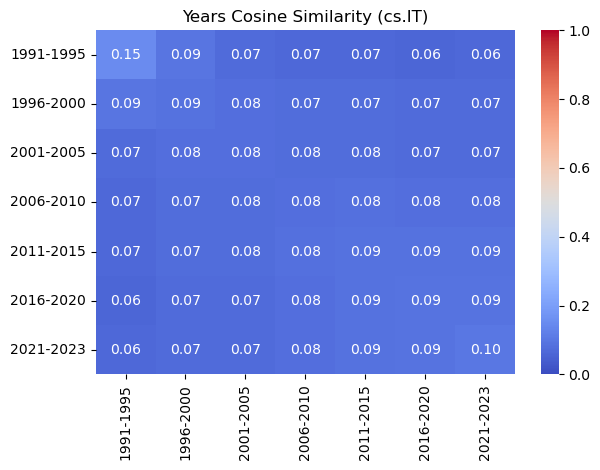

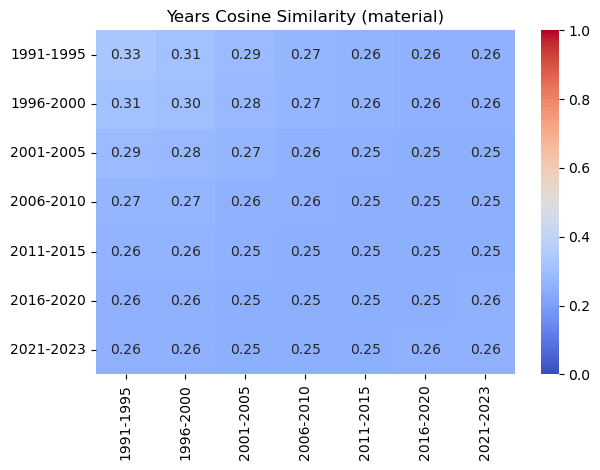

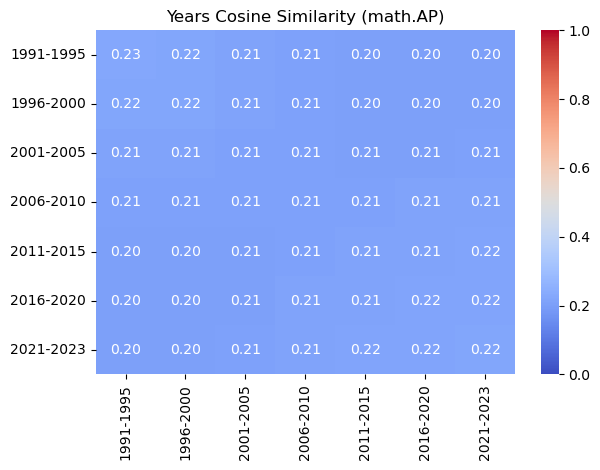

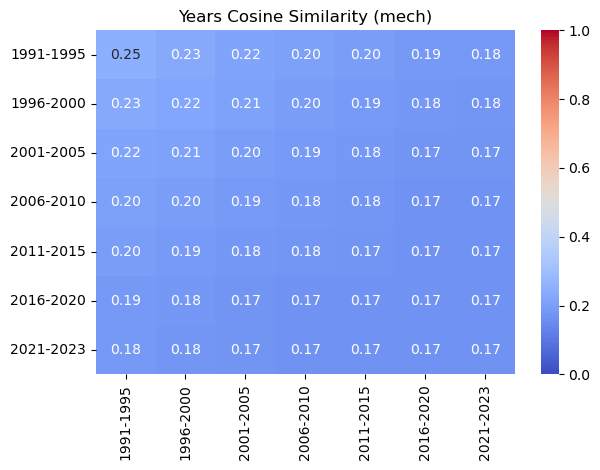

In [72]:
for i in range(11):
    create_year_matrix(cos_clusters[i,1:,1:], title=f'Years Cosine Similarity ({names[i]})', name=f'cos_matrix_{i}.png', fmt=".2f")

In [39]:
print(years.shape)
print(clusters.shape)
print(years[clusters==0].shape)
years_clusters = ((years-1986)/5).astype(int)
print(years)
print(clusters[years_clusters==0])
print(len(np.where((clusters==9) & (years_clusters==0))[0]))

npaper = np.zeros((8, 11), dtype = int)
for i in range(8):
        for j in range(11):
            npaper[i, j] = len(np.where((years_clusters==i) & (clusters==j))[0])

normalized_npaper=  npaper/npaper.sum(axis=0)

print(normalized_npaper)

print(normalized_npaper.sum(axis=1)/11)


(2370685,)
(2370685,)
(203648,)
[2007 2008 2008 ... 1996 1996 1996]
[4 4 2 9 9 9 9 9 0 9 9 0 0 9 9 4 0 9 0 4 4 4 2 9 0 9 9 9 0 4 2]
14
[[3.43730358e-05 0.00000000e+00 1.68635960e-05 0.00000000e+00
  4.76122459e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 7.77786420e-05 0.00000000e+00]
 [1.73976666e-02 9.72337433e-03 4.51438465e-02 4.33684006e-02
  3.63893593e-03 6.33485193e-04 8.16314033e-03 1.64004607e-03
  1.19989463e-02 7.55563951e-03 1.23023227e-02]
 [4.53183925e-02 7.37836766e-02 1.09472844e-01 1.22602590e-01
  1.19710790e-02 1.57802300e-03 4.63394470e-02 5.75523518e-03
  5.74921183e-02 2.46002733e-02 5.55846710e-02]
 [8.69343180e-02 1.27864536e-01 1.42087039e-01 1.50747103e-01
  4.03479775e-02 1.44904996e-03 1.04314278e-01 1.80525659e-02
  1.08398413e-01 5.50117224e-02 9.95423774e-02]
 [1.49331199e-01 1.73491543e-01 1.64931590e-01 1.67487062e-01
  1.11160991e-01 4.16507031e-03 1.45748492e-01 6.10675976e-02
  1.53266994e-01 1.26684741e-01 1.42943589e-01]
 [2.1

In [133]:
def create_histograms(clusters, years, names):
    folder_name="Histograms"
    
    years_clusters = ((years-1986)/5).astype(int)
    
    years_name = ['1986\n-1990', '1991\n-1995', '1996\n-2000', '2001\n-2005', '2006\n-2010', '2011\n-2015', '2016\n-2020', '2021\n-2023']
    
    npaper = np.zeros((8, 11))
    for i in range(8):
        for j in range(11):
            npaper[i, j] = len(np.where((years_clusters==i) & (clusters==j))[0])
            if i == 7:
                npaper[i,j] = npaper[i, j] * 5 / 3


    normalized_npaper=npaper/npaper.sum(axis=0)
    
    all_paper = normalized_npaper.sum(axis=1)/11
    
    # plt.figure()
    # plt.title(f"Histogram of all categories")
    # plt.bar(years_name, all_paper)
    # plt.xlabel("Year")
    # plt.ylabel("Frequency")
    # save_path = os.path.join(folder_name, f'all.png')    
    # plt.ylim(-0.02, 0.75)
    # plt.savefig(save_path)
    # plt.close
    
    # for j in range(11):
    #     plt.figure()
    #     plt.title(f"Histogram of {names[j]}")
    #     plt.bar(years_name, normalized_npaper[:,j])
    #     plt.xlabel("Year")
    #     plt.ylabel("Frequency")
    #     plt.ylim(-0.05, 0.75)
    #     save_path = os.path.join(folder_name, f'{names[j]}.png')    
    #     plt.savefig(save_path)
    #     plt.close
        
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for j in range(11):
        ax.bar(years_name, normalized_npaper[:, j], zs=j, zdir='y', alpha=0.8)
    
    ax.set_xlabel('Year', labelpad=10)
    ax.set_ylabel('Category', labelpad=20)
    ax.set_zlabel('Frequency', labelpad=10)
    plt.xticks(rotation=-15, size=6)
    plt.yticks(rotation=-5, size=7, ha='left', va='bottom')
    ax.set_yticks(range(len(names)))
    ax.set_yticklabels(names)
    plt.title(f"3D Histogram of all categories")

    save_path = os.path.join(folder_name, f"3d_all.png")
    plt.savefig(save_path)
    plt.show()
    # logging.info(f"Saved 3D histogram for top 10 categories in {output_path_3d}")
    plt.close()

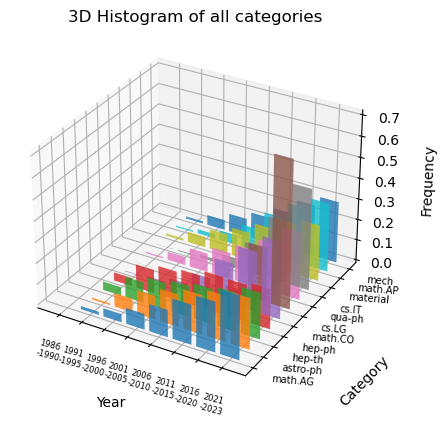

In [134]:
create_histograms(clusters, years, names)